<img src="./logo_UNSAM.jpg" align="right" width="150" />

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº5
#### Tobías Domenech

## Introducción

El siguiente trabajo tratara sobre la estimación espectral y calculo del ancho de banda para señales reales como son el electrocardiograma (ECG), los resultados de la plestimografía (PPG) y  distintas señales de audio. Como consignas se tiene: 

1) Realizar la estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

2) Realice una estimación del ancho de banda de cada señal y presente los resultados en un tabla para facilitar la comparación.

En este caso, el método de estimación espectral utilizado será el de Blackman-Tukey.

## Desarrollo y Resultados

Como quedará plasmado en el código a continuación, la manera que se utilizará en este trabajo para estimar el ancho de banda de las distintas señales será, primeramente, mediante la estimación de la densidad espectral de potencia de las señales, usando el método de Blackman-Tukey. Con dicha información se procederá a calcular la energía total de la señal mediante la integración en frecuencia de la PSD, para luego calcular la energía acumulada hasta cada bin de frecuencia y, al normalizarlo por la energía total de la señal, poder conocer el porcentaje de energía que se encuentra acumulado para una determinada frecuencia. De esta forma, se buscará alcanzar el 95% y 98% de acumulación de la energí total para definir el estimador del ancho de banda. 

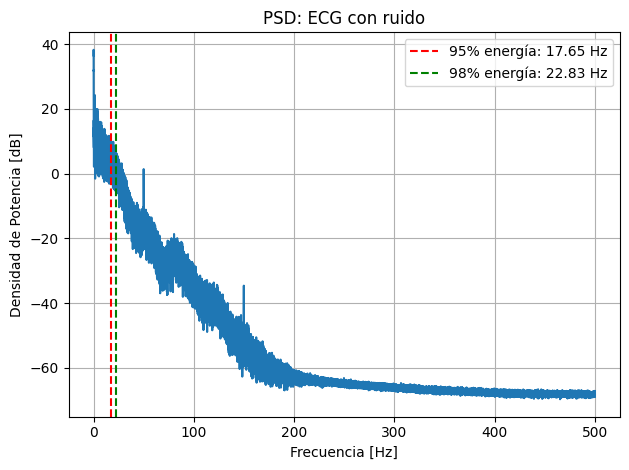

Frecuencia al 95% de la energía acumulada: 17.65 Hz
Frecuencia al 98% de la energía acumulada: 22.83 Hz


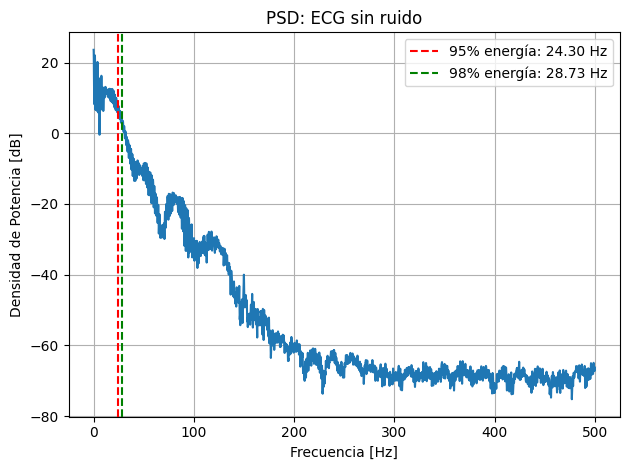

Frecuencia al 95% de la energía acumulada: 24.30 Hz
Frecuencia al 98% de la energía acumulada: 28.73 Hz


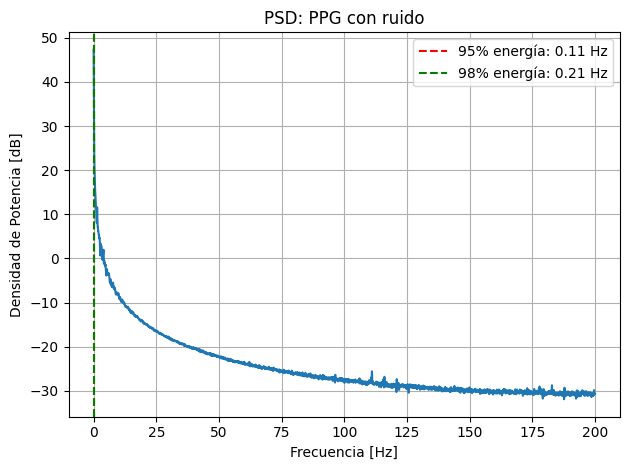

Frecuencia al 95% de la energía acumulada: 0.11 Hz
Frecuencia al 98% de la energía acumulada: 0.21 Hz


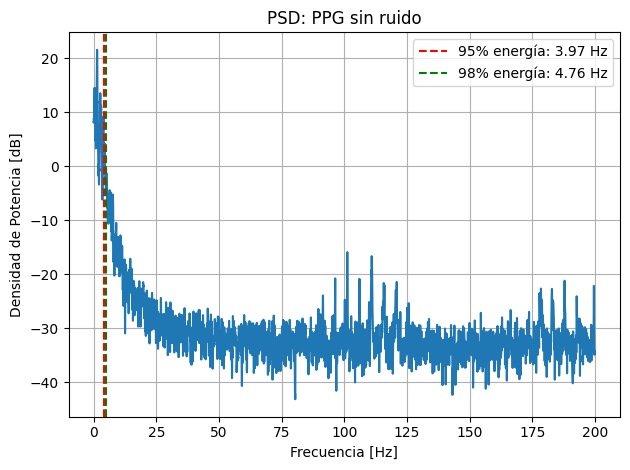

Frecuencia al 95% de la energía acumulada: 3.97 Hz
Frecuencia al 98% de la energía acumulada: 4.76 Hz


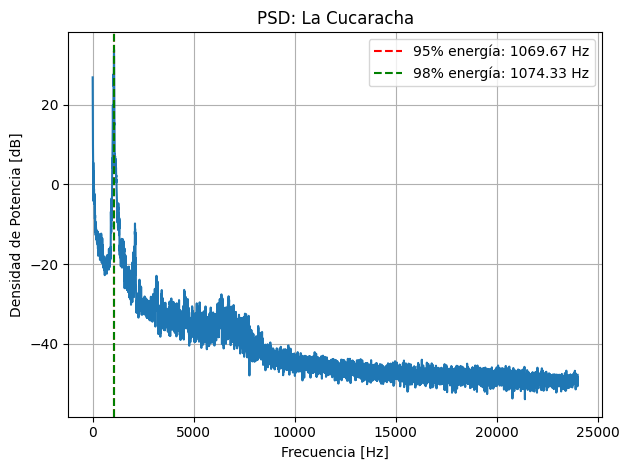

Frecuencia al 95% de la energía acumulada: 1069.67 Hz
Frecuencia al 98% de la energía acumulada: 1074.33 Hz


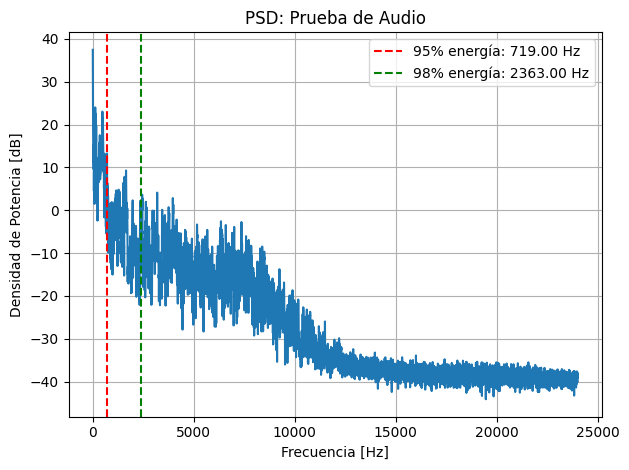

Frecuencia al 95% de la energía acumulada: 719.00 Hz
Frecuencia al 98% de la energía acumulada: 2363.00 Hz


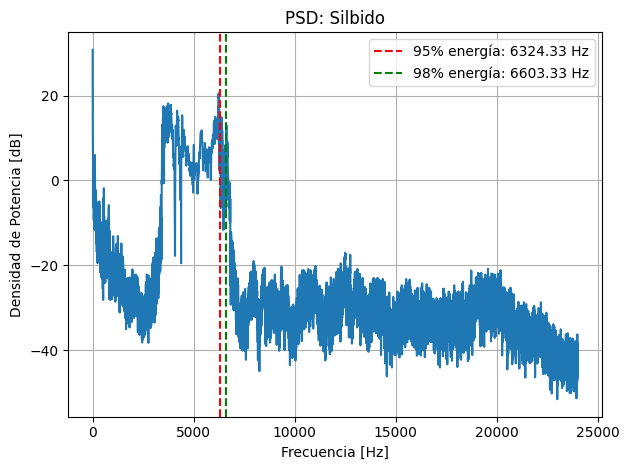

Frecuencia al 95% de la energía acumulada: 6324.33 Hz
Frecuencia al 98% de la energía acumulada: 6603.33 Hz


,Ancho de Banda al 95% [Hz],Ancho de Banda al 98% [Hz]
ECG con ruido,17.65,22.83
ECG sin ruido,24.30,28.73
PPG con ruido,0.11,0.21
PPG sin ruido,3.97,4.76
La cucaracha,1069.67,1074.33
Prueba de audio,719.00,2363.00
Silbido,6324.33,6603.33


In [2]:
import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt
   
import scipy.io as sio
from scipy.io.wavfile import write

import pandas as pd

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)

def blackman_tukey(x,  M = None):    
    
    # N = len(x)
    x_z = x.shape
    
    N = np.max(x_z)
    
    if M is None:
        M = N//5
    
    r_len = 2*M-1

    # hay que aplanar los arrays por np.correlate.
    # usaremos el modo same que simplifica el tratamiento
    # de la autocorr
    xx = x.ravel()[:r_len];

    r = np.correlate(xx, xx, mode='same') / r_len

    Px = np.abs(np.fft.fft(r * sig.windows.blackman(r_len), n = N) )

    Px = Px.reshape(x_z)

    return Px;

def estimacion_PSD_y_BW (signal, fs, titulo = "Nombre de la señal", es_silbido = False):
    N = len(signal)
    
    
    if es_silbido:
        M = N // 4
    else:
        M = N // 10
    
    #Normalizo por varianza
    signal = signal/np.std(signal)
    
    
    #Aplico B-T
    psd = blackman_tukey(signal, M)
    
    ff = np.linspace(0, fs, N, endpoint=False)
    
    # Corroborar Parseval y calculo de energía acumulada
    
    ft_signal = np.fft.fft(signal)
    ft_SIGNAL = np.abs(ft_signal ** 2)
    parseval = np.mean(ft_SIGNAL)
    
    energia = np.sum(signal ** 2)
    
    # Busco trabajar con una proporcion del 95 - 98% de la potencia
    # Trabajo con la mitad de los datos
    mitad_psd = psd[:N//2]
    
    # Energia total
    
    ener_total = np.sum(mitad_psd)
    
    # Energia acumulada normalizada por total
    
    ener_acumulada = np.cumsum(mitad_psd)/ener_total
    
    # Estimación ancho de banda
    
    mitad_ff = ff[:N//2]
    
    indice_95 = np.where(ener_acumulada >= 0.95)[0][0]
    f95 = mitad_ff[indice_95]
    indice_98 = np.where(ener_acumulada >= 0.98)[0][0]
    f98 = mitad_ff[indice_98]
    
    # Gráfico PSD
    plt.plot( ff[:N//2], 10* np.log10( np.abs(psd[:N//2]) + 1e-10) )
    plt.axvline(x=f95, color='r', linestyle='--', label=f'95% energía: {f95:.2f} Hz')
    plt.axvline(x=f98, color='green', linestyle='--', label=f'98% energía: {f98:.2f} Hz')
    plt.ylabel('Densidad de Potencia [dB]')
    plt.xlabel('Frecuencia [Hz]')
    plt.title(f'PSD: {titulo}')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Frecuencia al 95% de la energía acumulada: {f95:.2f} Hz")
    print(f"Frecuencia al 98% de la energía acumulada: {f98:.2f} Hz")
 
    
    return f95, f98;

#%%

##################
# Lectura de ECG #
##################

fs_ecg = 1000 # Hz

##################
## ECG con ruido
##################

# para listar las variables que hay en el archivo
#io.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg_noise = vertical_flaten(mat_struct['ecg_lead'])
ecg_noise = mat_struct['ecg_lead'].reshape(-1, 1)

f95_ECG_noise, f98_ECG_noise = estimacion_PSD_y_BW (ecg_noise, fs_ecg, titulo = "ECG con ruido" )


##################
## ECG sin ruido
##################

ecg_limpio = np.load('ecg_sin_ruido.npy')

f95_ECG_limpio, f98_ECG_limpio = estimacion_PSD_y_BW (ecg_limpio, fs_ecg, titulo = "ECG sin ruido" )

#%%

####################################
# Lectura de pletismografía (PPG)  #
####################################

fs_ppg = 400 # Hz

##################
## PPG con ruido
##################

# # Cargar el archivo CSV como un array de NumPy
ppg_noise = np.genfromtxt('PPG.csv', delimiter=',', skip_header=1)  # Omitir la cabecera si existe
f95_PPG_noise, f98_PPG_noise = estimacion_PSD_y_BW (ppg_noise, fs_ppg, titulo = "PPG con ruido" )

##################
## PPG sin ruido
##################

ppg_limpio = np.load('ppg_sin_ruido.npy')

f95_PPG_limpio, f98_PPG_limpio = estimacion_PSD_y_BW (ppg_limpio, fs_ppg, titulo = "PPG sin ruido" )


#%%

####################
# Lectura de audio #
####################

# Cargar el archivo CSV como un array de NumPy

fs_audio, wav_data = sio.wavfile.read('la cucaracha.wav')
if wav_data.ndim > 1:
    wav_data = wav_data[:, 0]
wav_data = wav_data.astype(np.float64)
f95_cuca, f98_cuca = estimacion_PSD_y_BW (wav_data, fs_audio, titulo = "La Cucaracha" )

fs_audio2, wav_data2 = sio.wavfile.read('prueba psd.wav')
if wav_data2.ndim > 1:
    wav_data2 = wav_data2[:, 0]
wav_data2 = wav_data2.astype(np.float64)
f95_pruebapsd, f98_pruebapsd = estimacion_PSD_y_BW (wav_data2, fs_audio2, titulo = "Prueba de Audio" )

fs_audio3, wav_data3 = sio.wavfile.read('silbido.wav')
if wav_data3.ndim > 1:
    wav_data3 = wav_data3[:, 0]
wav_data3 = wav_data3.astype(np.float64)
f95_silbido, f98_silbido = estimacion_PSD_y_BW (wav_data3, fs_audio3, titulo = "Silbido", es_silbido=True )

# Crear tabla de resultados
tabla = pd.DataFrame({
    "Ancho de Banda al 95% [Hz]": [
        f95_ECG_noise,
        f95_ECG_limpio,
        f95_PPG_noise,
        f95_PPG_limpio,
        f95_cuca,
        f95_pruebapsd,
        f95_silbido
    ],
    "Ancho de Banda al 98% [Hz]": [
        f98_ECG_noise,
        f98_ECG_limpio,
        f98_PPG_noise,
        f98_PPG_limpio,
        f98_cuca,
        f98_pruebapsd,
        f98_silbido
    ]
}, index=[
    "ECG con ruido",
    "ECG sin ruido",
    "PPG con ruido",
    "PPG sin ruido",
    "La cucaracha",
    "Prueba de audio",
    "Silbido"
])

# Estilo para la tabla
tabla.style.set_caption("Estimación de Ancho de Banda al 95% y 98% de Energía") \
     .format("{:.2f}") \
     .set_table_styles([{
         "selector": "caption",
         "props": [("font-size", "16px"), ("font-weight", "bold")]
     }])

## Conclusiones

- Como observación general, más notable en el caso del PPG, se nota que la introducción de ruido en la distintas señales puede llegar a tener efectos de enmascaramiento de las características propias de la señal que se aprecian en su densidad espectral de potencia dada la introducción de energía a lo largo de todo el espectro. Este hecho genera un impacto, además de visible como se aprecia en los gráficos, sobre las estimaciones de los anchos de banda.

- Tanto para el caso del **ECG** como del **PPG** el hecho de analizar la señal limpia y con ruido permite apreciar la afección de este último sobre la estimación del ancho de banda. En ambos casos, la introducción de ruido conlleva a una subestimación del ancho de banda, hecho esperable dado que, al mantener la búsqueda de los percentiles 95 y 98 de enrgía para estimar el ancho de banda, dichos montos de energía se acumularán a menores frecuencias, respecto de las señales limpias, dado que el ruido introducirá más energía en las frecuecnias bajas.

- En el caso de las señales de audio, se trata de casos donde las señales no presentan ruido de fondo que logre afectarlas, dejando señales considerablemente limpias. Notese que en el caso de **prueba de audio**, los valores de frecuencia obtenidos para la acumulación del 95% y 98% de la energía difieren en gran manera entre ellos, por lo tanto, la elección de uno u otro para la estimación del ancho de banda tendrá gran relevancia.
